## Sample Code for Classifying Manifestos into Topics
### Guillermo Lezama 
#### Any questions, suggestions or comments, please send me an email to: guillelezama@pitt.edu
In this code I reproduce some of the analysis I have performed for one of the papers on my dissertation. The main goal is to understand which issues are politicians discussing in their proposals. I scraped pdfs with the proposals of 11,422 mayoral candidates for the 2012 election in Brazil. The data was already split into lines of text, and I coded manually 100 manifestos into 10 topics. I am using this sample to train a model and apply it to all the sentences in the corpus.
The steps are:

1. Load packages
2. Write cleaning programs
3. Load the data
4. Process and split the data into train and test
5. Run four different sets of models
6. Choose the best model
7. Predict the issues for each line in the whole corpus
8. Present descriptives

Before implementing this code, I cleaned the dataset. Each manifesto was scraped from the TSE website using the candidate's id and a python code. I then transformed the pdf into a json spliting it into lines. Check '\Examples' to look at a pdf and json example.

After that, I compiled all the jsons into a dataframe that is what I use in this code as an input.

Inputs:
* Stop words lists
* lineas_id1.csv and lineas_id2.csv. These are the manually classified manifestos.
* lineas_id_tot.csv is the set of all lines in the corpus with the correspondent candidates' id

Outputs:
* File with probabilistic classification for each line in the corpus: topic_probs.csv

In [1]:
# Importing necessary packages
import json  # for working with JSON data
import os  # for interacting with the operating system, for example, navigating directories, creating files, etc.
import re  # for working with regular expressions
from collections import Counter  # for counting the occurrences of elements in a list or other iterable
import pandas as pd  # for working with data in tabular form, similar to spreadsheets or SQL tables
from os import listdir  # another way to interact with the operating system, specifically for listing files in a directory
from os.path import isfile, join  # used in conjunction with listdir to filter out non-file elements from the list
import pdfplumber  # for extracting text and data from PDF files
from datetime import datetime  # for working with dates and times
import numpy as np  # for working with numerical data, especially arrays and matrices
import random  # for generating random numbers and shuffling lists
import joblib  # for caching and parallelizing computations, especially in machine learning tasks
from joblib import dump, load  # specifically for saving and loading machine learning models
import matplotlib.pyplot as plt  # for creating visualizations, particularly charts and graphs
from sklearn.naive_bayes import MultinomialNB  # a type of classifier for text classification
from sklearn import model_selection, naive_bayes  # for cross-validation and other machine learning functions
from sklearn.neighbors import KNeighborsClassifier  # another type of classifier for text classification
from sklearn.model_selection import GridSearchCV  # for hyperparameter tuning of machine learning models
from sklearn.pipeline import Pipeline  # for building a pipeline of machine learning steps
from sklearn.feature_extraction.text import TfidfVectorizer  # for feature extraction using TF-IDF
from sklearn.metrics import accuracy_score, confusion_matrix  # for evaluating the performance of machine learning models
from nltk import wordpunct_tokenize  # for tokenizing text into words and punctuation marks
from nltk.tokenize import word_tokenize  # another way to tokenize text, specifically for words only
from nltk.stem.snowball import SnowballStemmer  # for stemming words, specifically for the Portuguese language
from nltk.corpus import stopwords  # for removing stop words from text

# Initializing a SnowballStemmer object for Portuguese
snowballStemmer = SnowballStemmer("portuguese")

In [2]:
# Defining Stop-word lists. Besides the usual stop words, I also remove state names, party names, and first and last names of candidates. 

stop2= stopwords.words("portuguese")
estados= ['Acre', 'AC',
'Alagoas', 'AL',
'Amapá', 'AP',
'Amazonas', 'AM',
'Bahia', 'BA',
'Ceará', 'CE',
'Distrito', 'Federal', 'DF',
'Espírito', 'Santo', 'ES',
'Goiás', 'GO',
'Maranhão', 'MA',
'Mato', 'Grosso', 'MT',
'Mato', 'Grosso', 'do', 'Sul', 'MS',
'Minas', 'Gerais', 'MG',
'Pará', 'PA',
'Paraíba', 'PB',
'Paraná', 'PR',
'Pernambuco', 'PE',
'Piauí', 'PI',
'Rio', 'de', 'Janeiro', 'RJ',
'Rio', 'Grande', 'do', 'Norte', 'RN',
'Rio', 'Grande', 'do', 'Sul', 'RS',
'Rondônia', 'RO',
'Roraima', 'RR',
'Santa', 'Catarina', 'SC',
'São', 'Paulo', 'SP',
'Sergipe', 'SE',
'Tocantins', 'TO' ]
lugares = ['manaus', 'paricatuba', 'solimões', 'marajó']
other= ['with', 'without', 'novapdf', 'create', 'created', 'version', 'purchasing', 'this', 'gmailcom', 'gmail', 'pdf', 'art', 'end', 'did', 'files', 'printer', 'acom'
        , 'poty', 'ibge_y', 'ibge_x', 'id','nr_partido','gini_y','linc_y','lpop','auditrecent12','concorre_reeleicao','fem_y','alguien','count_par','podia_y','stateid2', 'indexbueno']
estados=[x.lower() for x in estados]
partidos= ['psb','psol', 'pstu', 'phs', 'ppl', 'pco', 'pdt', 'pmdb', 'pmbd', 'psc', 'pmn', 'pcdob', 'dem', 'prb', 'prtb', 'pps', 'psdc', 'psdb' ,'psd', 'ptn', 'ptc', 'ptdob', 'prb', 'prp', 'phs', 'pcb']

munic=pd.read_excel("munic_cand.xlsx")['nm_ue'].tolist()
lista=[]
for i in range(0, len(munic)):
    lista = lista + word_tokenize(munic[i])
lista=[x.lower() for x in lista]
lista = list(set(lista))

stop= stop2 + estados +other + lugares +partidos + lista


In [3]:
# Defining cleaning functions

# Define a function called 'tokenize' that takes a string argument and returns a list of its words
def tokenize(text):
    return text.split()

# Define a function called 'tokenize_snowball' that takes a string argument and returns a list of its words with each word stemmed using the snowballStemmer
def tokenize_snowball(text):
    return [snowballStemmer.stem(word) for word in text.split()]

# Analysis

In [4]:
# Importing already classified manifiestos
df1=pd.read_csv('lineas_id1.csv').loc[:8086]
df1=df1.rename(columns={' id ': "id"})
df2=pd.read_csv('lineas_id2.csv')
df=df1.append(df2).reset_index()
df.head()

,index,Unnamed: 0,0,id,Unnamed: 3
0,0,0,PLANO DE TRABALHO PARA LUZINÓPOLIS/TO,"270,000,010,503",Titulo
1,1,1,AÇÕES E METAS,"270,000,010,503",Titulo
2,2,2,COLIGAÇÃO,"270,000,010,503",Titulo
3,3,3,“QUEM É DAQUI FAZ MELHOR”,"270,000,010,503",Titulo
4,4,4,CANDIDATO,"270,000,010,503",Titulo


In [5]:
# Manual classification is performed using several categories that I group into 10 topics.
top1=['Titulo', 'Tiu']
top2=['Introduccion', 'General']
top3=['Servidores Publicos', 'Servidores publicos', 'Admin', 'Servidor Publico', 'Participacion', 'Admin y Participacion', 'Gestion', 'Gobierno', 'Finanzas']
top4=['Educacion y Deportes', 'Cultura y deporte','Turismo, Cultura y Deportes', 'Politicas sociales', 'Desarrollo social', 'Gender', 'Cultura y  Turismo', 'Politica social',
       'Deporte y Juventud', 'Deporte y Turismo', 'Educacion, Cultura y Deporta',
       'Cultura y Turismo', 'Educacion y Cultura','Asistencia social', 'Deporte, cultura, juventud y turismo', 'Educacion', 'Deporte y Cultura', 'Politica Social', 'Juventud', 'Infancia y Vejez', 'Deportes', 'Cultura', 'Asistencia Social', 'Cultura y Deporte', 'Juventud, Genero y Vejez', 'Discapacidad', 'Politicas Sociales', 'Deporte', 'Social', 'Desarrollo Social', 'Vejez', 'Educacion y Deporte', 'Cultura, deporte y turismo', 'Genero', 'Turismo']
top5=['Salud']
top6=['Transporte', 'Transito','Urbano y vivienda', 'Infraestructura y transporte','Desarrollo Urbano','Infraestructura', 'Urbana' , 'Vivienda', 'Urbano', 'Agua', 'Aguas', 'Calles', 'Limpieza', 'Luces', 'Saneamiento', 'Infraestructura y Servicios', 'Saneamiento y Ambiente', 'Desastres', 'Saneamietnto', 'Limpieza y Ambiente']
top7=['Ambiente y Agricultura','Agricultura', 'Rural', 'Ambiene y Agricultura','Agricultura y Ambiente', 'Ambiente','Desarrollo sustentable', 'Produccion', 'Desarrollo Sustentable', 'Desarrollo Economico y Sustentable','Empleo e Ingresos', 'Desarrollo Economico', 'Desarrollo','Industria y Comercio', 'Empleo', 'Empleo e ingresos', 'Desarrollo Sostenible', 'Economia Solidaria', 'Empleo y Renta']
top8=['Trash', 'nan','Vacio']
top9=['Seguridad']
top10=['Centro de Eventos', 'Funerarios', 'Comunicacion', 'Other', 'Otros', 'Religion']

In [6]:
# Create a new column in the DataFrame called 'top' and initialize all values to 0
df['top'] = 0

# Loop over the values 1 to 10
for i in range(1, 11):
    # Get the value of the variable 'topX' where X is the current value of i
    top_list = globals()['top{}'.format(i)]
    # Set the value of 'top' to i for any rows where the value in the 'Unnamed: 3' column is in the list 'top_list'
    df.loc[df['Unnamed: 3'].isin(top_list), 'top'] = i

In [7]:
# Frequency of each topic in the set of manually classified manifestos.
df.groupby('top').count()['index']/len(df)*100

top
0      0.004066
1      2.850405
2     14.719636
3      8.303176
4     31.256862
5      9.494572
6     10.559915
7     13.902330
8      6.209084
9      2.451917
10     0.248038
Name: index, dtype: float64

In [8]:
## There are two ways to split this manually classified lines into train-test sets.  First, I use a 75-25 train-set split. 
# I can split the set of manifestos (and keeping lines of a manifesto together), or I can split the set of lines.
# Splitting manifestos
df5=df.groupby('id').first()
df5['id2']=df5.index
a=int(len(df5)*3/4)
df6 = df5.reset_index(drop=True)
idlist=df6[df6.index<a]['id2'].tolist()
noidlist=df6[df6.index>=a]['id2'].tolist()
X_train2= df[df['id'].isin(idlist)]['0'].values
y_train2 = df[df['id'].isin(idlist)]["top"].values
X_test2 = df[df['id'].isin(noidlist)]['0'].values
y_test2 = df[df['id'].isin(noidlist)]["top"].values

In [9]:
# Splitting lines
a=int(len(df)*3/4)
df4 = df.reset_index(drop=True)
X_train1= df4.loc[:a, '0'].values
y_train1 = df4.loc[:a, "top"].values
X_test1 = df4.loc[a:, '0'].values
y_test1 = df4.loc[a:, "top"].values

# Models
I compare a Naive Bayes Multinomial model with a K-neighbors model. In both cases I look at the accuracy score and compare the train-test split made with manifestos or with lines. In the case I split manifestos into train-test sets, I can also make an interpolating correction. If a line is classified into topic X, the following line is classified into topic Y, and the following at topic X, I correct the middle one and I compute it as topic X. I check the accuracy of this correction too.

In [10]:
results=pd.DataFrame() ## I will compare models using this dataframe

## NB

In [11]:
# NB, programs

# assign the input and output variables for train and test sets
X_train = X_train2
y_train = y_train2
X_test = X_test2
y_test = y_test2

# initialize the variables to be used later
p = 0 # for storing the index in results dataframe
t = 0 # for iterating over unique values of id in test set
n = 0 # for keeping count of number of values adjusted in df_test['test2']

# create a pipeline for TfidfVectorizer and MultinomialNB classifier
pipeline = Pipeline([("vect", TfidfVectorizer()),("clf", naive_bayes.MultinomialNB())])

# define the parameters for GridSearchCV
params = [
    {
        "vect__ngram_range": [(1,1), (1,2)], # for unigrams and bigrams
        "vect__stop_words": [stop, None], # with and without stop words
        "vect__tokenizer": [tokenize, tokenize_snowball], # different tokenizers
        "clf__alpha": [0.01, 0.1, 0.5, 1.0, 3.0, 10.0] # different alpha values for the classifier
    }
]

# define the GridSearchCV with the above parameters
grid = GridSearchCV(estimator=pipeline, param_grid=params, scoring='accuracy', cv=5, verbose=1, n_jobs=4)

# train the model with GridSearchCV
grid.fit(X_train, y_train)

# get the best estimator from the grid
model1 = grid.best_estimator_

# dump the model to a file for later use
dump(model1, 'NB_progs'+'.joblib')

# make predictions on the test set using the best estimator
predictions_SVC = model1.predict(X_test)

# create a DataFrame with id and true values for the test set
df_test = pd.DataFrame(zip(df[df['id'].isin(noidlist)]['id'], y_test))
# add a column to the DataFrame with the predicted values
df_test['pred'] = predictions_SVC

df_test['test2']=df_test['pred']
# iterate over unique values of id in test set
for i in df_test[0].unique():
    # iterate over the rows with the same id
    for j in df_test[df_test[0] == i].index:
        try:
            # if the previous and next rows have the same predicted value
            if df_test[df_test[0] == df_test[0].unique()[t]].loc[j-1]['pred'] == df_test[df_test[0] == df_test[0].unique()[t]].loc[j+1]['pred']:
                # adjust the predicted value of the current row to match the values of the previous and next rows
                df_test['test2'].loc[j] = df_test['pred'][j-1]
                n += 1
        except:
            pass
    t += 1

# calculate the accuracy scores and store the results in a DataFrame
results_i = {}
results_i['type_random'] = 'progs'
results_i['method'] = 'NB'
results_i['acu_pred'] = accuracy_score(y_test, predictions_SVC)
results_i['acu_adj'] = accuracy_score(y_test, df_test['test2'])
results_i['acu_pred_admin'] = ((pd.DataFrame(zip(y_test, predictions_SVC))[pd.DataFrame(zip(y_test, predictions_SVC))[0] == 3].groupby(1).count()) / (sum(pd.DataFrame(zip(y_test, predictions_SVC))[0] == 3)))[0][3]
results=results.append(pd.DataFrame(results_i, index=[p]))


Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\guill\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
C:\Users\guill\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [12]:
# NB, sentences
# Set the training and testing data
X_train = X_train1
y_train = y_train1
X_test = X_test1
y_test = y_test1

# Set the initial value of p to 1
p = 1

# Create a pipeline that first applies the TfidfVectorizer to the text data and then trains a Naive Bayes classifier
pipeline = Pipeline([
    ("vect", TfidfVectorizer()),
    ("clf", naive_bayes.MultinomialNB())
])

# Set the parameters to be used in the grid search. The grid search will try different combinations of ngram range, stop words, tokenizer, and alpha values to find the best set of hyperparameters.
params = [{
    "vect__ngram_range": [(1,1), (1,2)],
    "vect__stop_words": [stop, None],
    "vect__tokenizer": [tokenize, tokenize_snowball],
    "clf__alpha": [0.01, 0.1, 0.5, 1.0, 3.0, 10.0]
}]

# Perform the grid search with 5-fold cross-validation and save the best model
grid = GridSearchCV(
    estimator=pipeline, 
    param_grid=params, 
    scoring='accuracy', 
    cv=5, 
    verbose=1, 
    n_jobs=4
)
grid.fit(X_train, y_train)
model1 = grid.best_estimator_
dump(model1, 'NB_sents'+'.joblib')

# Use the best model to make predictions on the test data and calculate the accuracy score
predictions_SVC = model1.predict(X_test)
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
results_i = {}
results_i['type_random'] = 'sents'
results_i['method'] = 'NB'
results_i['acu_pred'] = accuracy_score(y_test, predictions_SVC)
results_i['acu_pred_admin'] = ((pd.DataFrame(zip(y_test, predictions_SVC))[pd.DataFrame(zip(y_test, predictions_SVC))[0]==3].groupby(1).count()) / (sum(pd.DataFrame(zip(y_test, predictions_SVC))[0]==3)))[0][3]

# Append the results to a pandas DataFrame
results = results.append(pd.DataFrame(results_i, index=[p]))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\guill\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


# K-Neighbors

In [13]:
# Kneigh, programas
# Assign values to the train and test datasets
X_train = X_train2
y_train = y_train2
X_test = X_test2
y_test = y_test2

# Set a parameter
p = 2

# Create a pipeline for the model
pipeline = Pipeline([("vect", TfidfVectorizer()),
                     ("clf", KNeighborsClassifier())])

# Define the parameters to be used in the grid search
params = [{"vect__ngram_range": [(1,1), (1,2)],
           "vect__stop_words": [stop, None],
           "vect__tokenizer": [tokenize, tokenize_snowball],
           'clf__p': [1,2],
           'clf__n_neighbors': [ 1,  2, 5, 10, 15, 20]  }]

# Create a grid search object
grid = GridSearchCV(estimator=pipeline, param_grid=params, scoring='accuracy', cv=5, verbose=1, n_jobs=4)

# Fit the model with the training data
grid.fit(X_train, y_train)

# Get the best estimator from the grid search
model1 = grid.best_estimator_

# Use the model to make predictions on the test data
predictions_SVC = model1.predict(X_test)

# Save the model
dump(model1, 'kneigh_progs'+'.joblib')

# Create a DataFrame to hold the test and predicted values
df_test = pd.DataFrame(zip(df[df['id'].isin(noidlist)]['id'],y_test))
df_test['pred'] = predictions_SVC

# Adjust the predicted values based on previous and following values
t = 0
n = 0
df_test['test2'] = df_test['pred']
for i in df_test[0].unique():
    for j in df_test[df_test[0]==i].index:
        try:
            if df_test[df_test[0]==df_test[0].unique()[t]].loc[j-1]['pred'] == df_test[df_test[0]==df_test[0].unique()[t]].loc[j+1]['pred']:
                df_test['test2'].loc[j] = df_test['pred'][j-1]
                n += 1
        except:
            pass
    t += 1

# Calculate the accuracy of the model
results_i = {}
results_i['type_random'] = 'progs'
results_i['method'] = 'KN'
results_i['acu_pred'] = accuracy_score(y_test, predictions_SVC)
results_i['acu_adj'] = accuracy_score(y_test, df_test['test2'])
results_i['acu_pred_admin'] = ((pd.DataFrame(zip(y_test, predictions_SVC))[pd.DataFrame(zip(y_test, predictions_SVC))[0]==3].groupby(1).count()) / (sum(pd.DataFrame(zip(y_test, predictions_SVC))[0]==3)))[0][3]
results_i['acu_adj_admin'] = ((pd.DataFrame(zip(y_test, df_test['test2']))[pd.DataFrame(zip(y_test, df_test['test2']))[0]==3].groupby(1).count()) / (sum(pd.DataFrame(zip(y_test, df_test['test2']))[0]==3)))[0][3]
results = results.append(pd.DataFrame(results_i, index=[p]))

Fitting 5 folds for each of 96 candidates, totalling 480 fits


C:\Users\guill\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
C:\Users\guill\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['-don', 'aarã', 'abad', 'abadi', 'abadiân', 'abaet', 'abai', 'abaix', 'abar', 'abati', 'abaír', 'abelard', 'abelarzinh', 'abobrinh', 'abra', 'abrahã', 'abrant', 'abraã', 'abreulând', 'abrã', 'abíli', 'acac', 'academ', 'acaiac', 'acajutib', 'acar', 'acarap', 'accaci', 'acegu', 'acelin', 'achill', 'acim', 'acinesi', 'acion', 'acopi', 'acord', 'acrelând', 'acreún', 'acáci', 'acássi', 'ada', 'adailm', 'adailt', 'adailz', 'adalbert', 'adalcin', 'adalgis', 'adalt', 'adam', 'adamantin', 'adari', 'adauri', 'adaut', 'adecim', 'adejuni', 'adelaid', 'adelbart', 'adelci', 'ade

C:\Users\guill\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [14]:
# Kneigh, sentences

# Set training and testing data for sentences
X_train= X_train1
y_train = y_train1
X_test = X_test1
y_test = y_test1

# Set value of p
p=3

# Define pipeline for K-Nearest Neighbors with TfidfVectorizer
pipeline = Pipeline([("vect", TfidfVectorizer()),
                ("clf", KNeighborsClassifier())])

# Define parameter grid for grid search
params = [{"vect__ngram_range": [(1,1), (1,2)],
             "vect__stop_words": [stop, None],
          "vect__tokenizer": [tokenize,
                              tokenize_snowball],
          'clf__p': [1,2],
          'clf__n_neighbors': [ 1,  2, 5, 10, 15, 20]  }]

# Perform grid search with cross-validation
grid = GridSearchCV(estimator=pipeline, param_grid=params, scoring='accuracy', cv=5, verbose=1, n_jobs=4)
grid.fit(X_train,y_train)

# Get the best estimator from grid search
model1 = grid.best_estimator_

# Make predictions on test data using the best estimator
predictions_SVC= model1.predict(X_test)

# Save the trained model
dump(model1, 'kneigh_sents'+'.joblib')

# Calculate and save evaluation metrics
results_i={}
results_i['type_random']='sents'
results_i['method']='KN'
results_i['acu_pred']=accuracy_score(y_test, predictions_SVC)
results_i['acu_pred_admin']=((pd.DataFrame(zip(y_test,predictions_SVC))[pd.DataFrame(zip(y_test,predictions_SVC))[0]==3].groupby(1).count())/(sum(pd.DataFrame(zip(y_test,predictions_SVC))[0]==3)))[0][3]
results=results.append(pd.DataFrame(results_i, index=[p]))



Fitting 5 folds for each of 96 candidates, totalling 480 fits


C:\Users\guill\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
C:\Users\guill\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['-don', 'aarã', 'abad', 'abadi', 'abadiân', 'abaet', 'abai', 'abaix', 'abar', 'abati', 'abaír', 'abelard', 'abelarzinh', 'abobrinh', 'abra', 'abrahã', 'abrant', 'abraã', 'abreulând', 'abrã', 'abíli', 'acac', 'academ', 'acaiac', 'acajutib', 'acar', 'acarap', 'accaci', 'acegu', 'acelin', 'achill', 'acim', 'acinesi', 'acion', 'acopi', 'acord', 'acrelând', 'acreún', 'acáci', 'acássi', 'ada', 'adailm', 'adailt', 'adailz', 'adalbert', 'adalcin', 'adalgis', 'adalt', 'adam', 'adamantin', 'adari', 'adauri', 'adaut', 'adecim', 'adejuni', 'adelaid', 'adelbart', 'adelci', 'ade

In [15]:
results

,type_random,method,acu_pred,acu_adj,acu_pred_admin,acu_adj_admin
0,progs,NB,0.508471,0.537928,0.453608,NaN
1,sents,NB,0.617987,NaN,0.378007,NaN
2,progs,KN,0.484790,0.509049,0.358247,0.340206
3,sents,KN,0.477964,NaN,0.309278,NaN


From looking at accuracy levels, I choose the model estimated with a Naive Bayes Model, and the train-test split using lines.

## Predicting in the corpus

In [16]:
# Loading the chosen model
filename =  'NB_sents.joblib'
best_model=joblib.load(filename)

In [17]:
# Read in a CSV file named 'lineas_id_tot.csv' and store it as a DataFrame named 'df_tot'
df_tot = pd.read_csv('lineas_id_tot.csv')

# Use the 'best_model' object to predict the target variable for the data in 'df_tot', and store the predictions in a new column called 'pred'
df_tot['pred'] = best_model.predict(df_tot['0'].astype(str))

# Use the 'best_model' object to get the predicted probabilities for the target variable for the data in 'df_tot', and store the probabilities in a new DataFrame called 'df_tot_probs'
df_tot_probs = best_model.predict_proba(df_tot['0'].astype(str))

# Merge the 'df_tot' DataFrame and the 'df_tot_probs' DataFrame by index, and store the result in a new DataFrame called 'probs'
probs = pd.merge(df_tot, pd.DataFrame(df_tot_probs), left_index=True, right_index=True)

# Multiply the predicted probabilities for each category by the number of words in each text (as determined by the length of each text after splitting on spaces), and store the result in a new column for each category (labeled 'E_1' through 'E_10')
for i in range(1,11):
    probs = probs.rename(columns={i: 'E_'+str(i)})
    probs['E_'+str(i)] = probs['0'].str.split().str.len() * probs['E_'+str(i)]

# Create a new DataFrame named 'df_tot_counts_prob'
df_tot_counts_prob = pd.DataFrame()

# For each category (labeled 'E_1' through 'E_10'), group the 'probs' DataFrame by 'id' and sum the values in the corresponding column, and store the result in a new DataFrame with a column named 'Exp_1' through 'Exp_10'
for i in range(1,11):
    df_top_m = pd.DataFrame(probs.groupby(['id'])['E_'+str(i)].sum())
    varname = 'Exp_'+str(i)
    df_top_m[varname] = df_top_m
    df_tot_counts_prob = pd.concat([df_tot_counts_prob, df_top_m[varname]], axis=1)

# Write the 'df_tot_counts_prob' DataFrame to a new CSV file named 'topic_probs.csv'
df_tot_counts_prob.to_csv('topic_probs.csv')

In [18]:
df_tot_counts_prob.head()

,Exp_1,Exp_2,Exp_3,Exp_4,Exp_5,Exp_6,Exp_7,Exp_8,Exp_9,Exp_10
10000000003,490.553983,8172.923244,2118.215779,12252.622980,2462.442415,3469.993623,4209.216527,127.260286,203.318366,5.396348
10000000007,72.710167,156.451975,31.672356,364.656899,118.320748,46.707734,69.953996,4.494965,4.848478,0.180957
10000000071,7.306723,355.792473,158.826845,1710.813342,315.578518,145.821917,502.421004,8.262485,16.776366,0.395799
10000000083,8.141570,47.124901,25.713793,477.499020,136.093904,116.210298,305.589919,1.703609,2.823044,0.098932
10000000165,12.286407,251.558950,138.105613,907.247537,200.611940,280.764168,406.062672,4.807260,18.327066,0.226347


## Analysis
Based on this dataset, there are not enough possibilities to do an analysis. However, I will analyze the word frequencies and their correlation with topic counts could be a useful approach.

By looking at the frequency of topics in the dataset, I can identify which topics occur most frequently and may be important in understanding the underlying topics or themes. Additionally, by examining the correlation between the total count of words and the total count for each topic, I may be able to look at non-linearities. Finally, I look at whether there is any pattern in the frequencies of topics regarding whether discussing some topics fosters or inhibit discussing another topic.

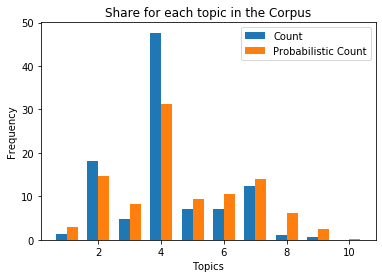

In [19]:
x = np.array(range(1,11))
y1 = np.array(df_tot.groupby('pred').count()['Unnamed: 0']/len(df_tot)*100)
y2 = np.array(df.groupby('top').count()['index']/len(df)*100)[1:11]

bar_width = 0.35

# Create bar chart with two series of bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - bar_width/2, y1, bar_width, label='Count')
rects2 = ax.bar(x + bar_width/2, y2, bar_width, label='Probabilistic Count')

# Add labels and title
ax.set_xlabel("Topics")
ax.set_ylabel("Frequency")
ax.set_title("Share for each topic in the Corpus")

# Add a legend
ax.legend()

# Show the plot
plt.show()

By using the probabilistic count, topic 4 is less predominant than in the discrete assignment. By gaining variability, I also reduce the measurement error at the document level.

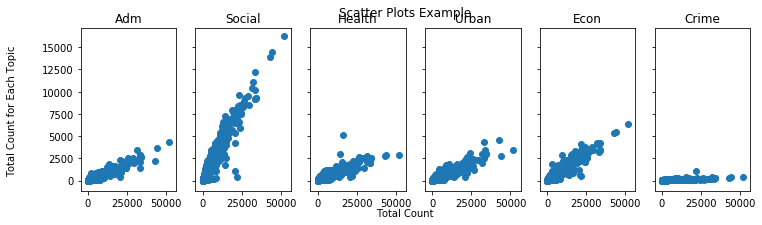

In [20]:

# Load data
y1 = df_tot_counts_prob['Exp_3']
y2 = df_tot_counts_prob['Exp_4']
y3 = df_tot_counts_prob['Exp_5']
y4 = df_tot_counts_prob['Exp_6']
y5 = df_tot_counts_prob['Exp_7']
y6 = df_tot_counts_prob['Exp_9']
x = df_tot_counts_prob.sum(axis=1)

# Create a figure with 6 subplots
fig, axs = plt.subplots(1, 6, figsize=(12, 3), sharex=True, sharey=True)

# Create scatter plot for each experiment
axs[0].scatter(x, y1)
axs[1].scatter(x, y2)
axs[2].scatter(x, y3)
axs[3].scatter(x, y4)
axs[4].scatter(x, y5)
axs[5].scatter(x, y6)

# Add labels and title
fig.text(0.5, 0.01, "Total Count", ha='center')
fig.text(0.04, 0.5, "Total Count for Each Topic", va='center', rotation='vertical')
fig.suptitle("Scatter Plots Example")

axs[0].set_title("Adm")
axs[1].set_title("Social")
axs[2].set_title("Health")
axs[3].set_title("Urban")
axs[4].set_title("Econ")
axs[5].set_title("Crime")

# Show the plot
plt.show()

The word-count for each topic relates linearly with the total word-count. An exception could be the Economic policy issue, where for low word-counts, there is more variability.

I then proceed to look at whether topics are substitutes (when more of topic X is discussed, less of topic Y is discussed) or complementaries (when more of topic X is discussed, more of topic Y is discussed)

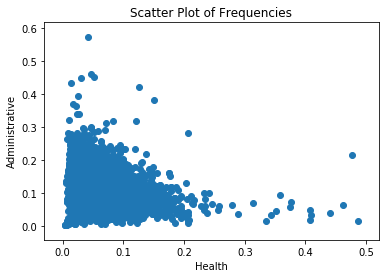

In [21]:
y =  df_tot_counts_prob['Exp_5']/df_tot_counts_prob.sum(axis=1)
x =  df_tot_counts_prob['Exp_3']/df_tot_counts_prob.sum(axis=1)

# Create bar chart
plt.scatter(x, y)
# Add labels and title
plt.xlabel("Health")
plt.ylabel("Administrative")
plt.title("Scatter Plot of Frequencies")

# Show the plot
plt.show()

#### Health and Administrative
They seem to be independent up to a certain point where they are substitutes (sum of both less than 0.3).

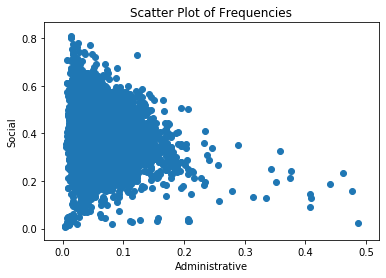

In [22]:
y =  df_tot_counts_prob['Exp_4']/df_tot_counts_prob.sum(axis=1)
x =  df_tot_counts_prob['Exp_3']/df_tot_counts_prob.sum(axis=1)

# Create bar chart
plt.scatter(x, y)
# Add labels and title
plt.xlabel("Administrative")
plt.ylabel("Social")
plt.title("Scatter Plot of Frequencies")

# Show the plot
plt.show()

#### Social and Administrative
There are almost no observations where Administrative $>$ Social. The other constraint seems to be that the sum of both seems to not be higher than 0.8.

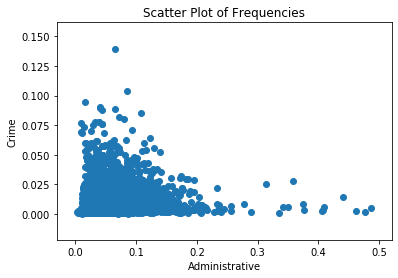

In [23]:
y =  df_tot_counts_prob['Exp_9']/df_tot_counts_prob.sum(axis=1)
x =  df_tot_counts_prob['Exp_3']/df_tot_counts_prob.sum(axis=1)

# Create bar chart
plt.scatter(x, y)
# Add labels and title
plt.xlabel("Administrative")
plt.ylabel("Crime")
plt.title("Scatter Plot of Frequencies")

# Show the plot
plt.show()

#### Crime and Administrative
The main constraint is that the sum of both seems to not be higher than 0.25.